# Stock Options Analysis

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import yfinance as yf
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)  # Set to display all columns of dataframes


## Data

Let us try to study the Black-Scholes Model, which require the information

i. ***Stock Price (S)***: the corresponding stock prices for each option.\

ii.***Strike Price (K)***: data under the column strike_price.

iii. ***Time to Expiry (T)***: subtracting the current date from the expiration date (exdate). Convert the resulting timedelta to years.

iv. ***Risk-free Interest Rate (r)***: determine an appropriate risk-free interest rate to use in the model. 

v. ***Volatility (σ)***: implied volatility, available in your data. 

### Load options data and download stock data

In [58]:
current_dir = os.getcwd()
# print("Current directory:", current_dir)


# Read the CSV file into a DataFrame
# option_data_file = '../data/option_data_2010_2024_cleaned.csv'
option_data_file = '../data/options_data.csv'

if os.path.exists(option_data_file):
    # If file exists, load it directly
    options_data = pd.read_csv(option_data_file)
else:    

    # options_data = pd.read_csv('../data/options_data.csv')
    options_data = pd.read_csv('../data/option_data_2010_2024.csv')

print(options_data.info())


/var/folders/q5/69ygwl597nd8rn5pmqr01b580000gn/T/ipykernel_51250/330244623.py:11: DtypeWarning: Columns (23,26,32) have mixed types. Specify dtype option on import or set low_memory=False.
  options_data = pd.read_csv(option_data_file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386118 entries, 0 to 1386117
Data columns (total 38 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   secid             1386118 non-null  int64  
 1   date              1386118 non-null  object 
 2   symbol            1386118 non-null  object 
 3   symbol_flag       1386118 non-null  int64  
 4   exdate            1386118 non-null  object 
 5   last_date         1263749 non-null  object 
 6   cp_flag           1386118 non-null  object 
 7   strike_price      1386118 non-null  int64  
 8   best_bid          1386118 non-null  float64
 9   best_offer        1386118 non-null  float64
 10  volume            1386118 non-null  int64  
 11  open_interest     1386118 non-null  int64  
 12  impl_volatility   1166644 non-null  float64
 13  delta             1166644 non-null  float64
 14  gamma             1166644 non-null  float64
 15  vega              1166644 non-null  float64
 16  

## Clean data

In [59]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386118 entries, 0 to 1386117
Data columns (total 38 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   secid             1386118 non-null  int64  
 1   date              1386118 non-null  object 
 2   symbol            1386118 non-null  object 
 3   symbol_flag       1386118 non-null  int64  
 4   exdate            1386118 non-null  object 
 5   last_date         1263749 non-null  object 
 6   cp_flag           1386118 non-null  object 
 7   strike_price      1386118 non-null  int64  
 8   best_bid          1386118 non-null  float64
 9   best_offer        1386118 non-null  float64
 10  volume            1386118 non-null  int64  
 11  open_interest     1386118 non-null  int64  
 12  impl_volatility   1166644 non-null  float64
 13  delta             1166644 non-null  float64
 14  gamma             1166644 non-null  float64
 15  vega              1166644 non-null  float64
 16  

In [60]:
options_data.isnull().sum()

secid                     0
date                      0
symbol                    0
symbol_flag               0
exdate                    0
last_date            122369
cp_flag                   0
strike_price              0
best_bid                  0
best_offer                0
volume                    0
open_interest             0
impl_volatility      219474
delta                219474
gamma                219474
vega                 219474
theta                219474
optionid                  0
cfadj                     0
am_settlement             0
contract_size             0
ss_flag                   0
forward_price       1386118
expiry_indicator     947992
root                1386118
suffix              1386118
cusip                     0
ticker                    0
sic                       0
index_flag                0
exchange_d                0
class               1386118
issue_type                0
industry_group      1351152
issuer                    0
div_convention      

In [61]:
options_data.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag
0,101121,2022-02-28,AMD 220304P143000,1,2022-03-04,2022-02-28,P,143000,18.30,21.70,1,43,0.919996,-0.931618,0.011129,1.700479,-71.04977,144642442,1,0,100,0,NaN,w,NaN,NaN,790310,AMD,3674,0,5,NaN,0,NaN,ADVANCED MICRO DEVICES INC.,NaN,A,NaN
1,101121,2022-02-28,AMD 220304P144000,1,2022-03-04,2022-02-22,P,144000,19.65,22.55,0,8,1.009123,-0.921234,0.011298,1.898582,-86.91409,144642443,1,0,100,0,NaN,w,NaN,NaN,790310,AMD,3674,0,5,NaN,0,NaN,ADVANCED MICRO DEVICES INC.,NaN,A,NaN
2,101121,2022-02-28,AMD 220304P145000,1,2022-03-04,2022-02-28,P,145000,20.45,23.70,3,154,1.029200,-0.926204,0.010543,1.805097,-84.34332,144642444,1,0,100,0,NaN,w,NaN,NaN,790310,AMD,3674,0,5,NaN,0,NaN,ADVANCED MICRO DEVICES INC.,NaN,A,NaN
3,101121,2022-02-28,AMD 220304P146000,1,2022-03-04,2022-02-28,P,146000,21.30,24.75,10,72,1.032943,-0.933979,0.009645,1.653858,-77.66636,144642445,1,0,100,0,NaN,w,NaN,NaN,790310,AMD,3674,0,5,NaN,0,NaN,ADVANCED MICRO DEVICES INC.,NaN,A,NaN
4,101121,2022-02-28,AMD 220304P147000,1,2022-03-04,2022-02-28,P,147000,23.50,25.75,6,86,1.347105,-0.879729,0.011528,2.587893,-158.53520,144642446,1,0,100,0,NaN,w,NaN,NaN,790310,AMD,3674,0,5,NaN,0,NaN,ADVANCED MICRO DEVICES INC.,NaN,A,NaN


#### Keep relevent columns, drop others

Drop all columns with all missing values and unnecessary categorical columns.

After dropping columns that do not have values, we have the remainging columns as below. We can drop more columns as we understand the nature of dataset and those columns may not influence our machine learning model. 

|secid:| Security ID, a unique identifier for each security.|
|---|---|
|date:| Date of the options data.|
|symbol:| Symbol of the security.|
|symbol_flag:| Flag indicating the type of symbol.|
|exdate:| Expiration date of the option.|
|last_date:| Last trading date of the option.|
|cp_flag:| Call (C) or Put (P) option flag.|
|strike_price:| Strike price of the option.|
|best_bid:| Best bid price for the option.|
|best_offer:| Best offer price for the option.|
|volume: Volume| of contracts traded.|
|open_interest:| Open interest for the option.|
|impl_volatility:| Implied volatility of the option.|
|delta:| Delta value of the option.|
|gamma:| Gamma value of the option.|
|vega:| Vega value of the option.|
|theta:| Theta value of the option.|
|optionid:| Option ID, a unique identifier for each option.|
|cfadj:| Adjustment factor for cash flow.|
|am_settlement:| American-style settlement flag.|
|contract_size:| Size of the contract.|
|ss_flag:| Special security flag.|
|expiry_indicator:| Expiry indicator, 'w' meaning weekly|
|cusip:| CUSIP number, a unique identifier for securities in the U.S. and Canada.|
|ticker: | Ticker symbol of the security.|
|sic:| Standard Industrial Classification (SIC) code.|
|index_flag:| Index security flag.|
|exchange_d:| Exchange identifier.|
|issue_type:| Type of issue.|
|industry_group:| Industry group.|
|issuer:| Issuer of the security.|
|exercise_style:| Exercise style of the option (e.g., American or European).|

In [62]:
# Drop all columns with all missing values
options_data.dropna(axis=1, how='all', inplace=True)


In [63]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386118 entries, 0 to 1386117
Data columns (total 32 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   secid             1386118 non-null  int64  
 1   date              1386118 non-null  object 
 2   symbol            1386118 non-null  object 
 3   symbol_flag       1386118 non-null  int64  
 4   exdate            1386118 non-null  object 
 5   last_date         1263749 non-null  object 
 6   cp_flag           1386118 non-null  object 
 7   strike_price      1386118 non-null  int64  
 8   best_bid          1386118 non-null  float64
 9   best_offer        1386118 non-null  float64
 10  volume            1386118 non-null  int64  
 11  open_interest     1386118 non-null  int64  
 12  impl_volatility   1166644 non-null  float64
 13  delta             1166644 non-null  float64
 14  gamma             1166644 non-null  float64
 15  vega              1166644 non-null  float64
 16  

In [64]:
# Drop some more categorical columns that are not necessary
# columns_to_drop =['secid', 'symbol', 'symbol_flag', 'last_date', 'optionid',
#                   'cfadj', 'am_settlement', 'ss_flag', 'expiry_indicator', 
#                   'exchange_d', 'issue_type', 'industry_group', 'issuer',
#                   'cusip', 'sic', 'index_flag', 'exercise_style'] 
# options_data = options_data.drop(columns=columns_to_drop)

columns_to_keep = ['date', 'exdate', 'cp_flag', 'strike_price',
                   'best_bid', 'best_offer', 'volume', 'open_interest',
                   'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 
                   'contract_size', 'ticker']
options_data = options_data[columns_to_keep]
# Here are the remaining columns


In [65]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386118 entries, 0 to 1386117
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1386118 non-null  object 
 1   exdate           1386118 non-null  object 
 2   cp_flag          1386118 non-null  object 
 3   strike_price     1386118 non-null  int64  
 4   best_bid         1386118 non-null  float64
 5   best_offer       1386118 non-null  float64
 6   volume           1386118 non-null  int64  
 7   open_interest    1386118 non-null  int64  
 8   impl_volatility  1166644 non-null  float64
 9   delta            1166644 non-null  float64
 10  gamma            1166644 non-null  float64
 11  vega             1166644 non-null  float64
 12  theta            1166644 non-null  float64
 13  contract_size    1386118 non-null  int64  
 14  ticker           1386118 non-null  object 
dtypes: float64(7), int64(4), object(4)
memory usage: 158.6+ MB


#### Convert date columns to datetime

In [66]:
# Explore categorical columns
print("\nUnique values in cp_flag column:", options_data['cp_flag'].unique())
print("\nUnique values in ticker column:", options_data['ticker'].unique())
print("\nUnique values in contract_size column:", options_data['contract_size'].unique())

unique_open_interest = options_data['open_interest'].unique()
print("\nUnique values in open_interest column:", options_data['open_interest'].unique())

# for oi in unique_open_interest:
#     print(oi)



Unique values in cp_flag column: ['P' 'C']

Unique values in ticker column: ['AMD' 'NVDA' 'TSM' 'SMCI']

Unique values in contract_size column: [100 172]

Unique values in open_interest column: [   43     8   154 ... 42576 14955 15329]


***open_interest***
ref: https://www.investopedia.com/terms/o/openinterest.asp#:~:text=Open%20interest%20is%20the%20total,tracking%20the%20total%20volume%20traded.

"Open interest is the total number of outstanding derivative contracts for an asset—such as options or futures—that have not been settled. Open interest keeps track of every open position in a particular contract rather than tracking the total volume traded."

In [67]:
# Explore numerical columns
print("\nSummary statistics of numerical columns:\n", options_data.describe())


Summary statistics of numerical columns:
        strike_price      best_bid    best_offer        volume  open_interest  \
count  1.386118e+06  1.386118e+06  1.386118e+06  1.386118e+06   1.386118e+06   
mean   1.640545e+05  3.690964e+01  3.829978e+01  2.198346e+02   1.229064e+03   
std    1.096561e+05  5.998198e+01  6.119734e+01  1.725485e+03   3.150095e+03   
min    5.000000e+03  0.000000e+00  1.000000e-02  0.000000e+00   0.000000e+00   
25%    8.500000e+04  8.500000e-01  1.200000e+00  0.000000e+00   7.000000e+00   
50%    1.300000e+05  1.095000e+01  1.175000e+01  1.000000e+00   1.590000e+02   
75%    2.150000e+05  4.620000e+01  4.850000e+01  2.875000e+01   9.540000e+02   
max    6.000000e+05  4.853000e+02  4.915500e+02  1.764690e+05   9.757500e+04   

       impl_volatility         delta         gamma          vega  \
count     1.166644e+06  1.166644e+06  1.166644e+06  1.166644e+06   
mean      6.532276e-01 -1.093080e-02  9.271234e-03  1.646618e+01   
std       3.339506e-01  5.886337

In [68]:
# Double-check null values
options_data.isnull().sum()

# We observed that there are some missing values of the implied volatility and the Greeks. 

date                    0
exdate                  0
cp_flag                 0
strike_price            0
best_bid                0
best_offer              0
volume                  0
open_interest           0
impl_volatility    219474
delta              219474
gamma              219474
vega               219474
theta              219474
contract_size           0
ticker                  0
dtype: int64

#### Convert datatime

In [69]:
options_data['date'] = pd.to_datetime(options_data['date'])
options_data['exdate'] = pd.to_datetime(options_data['exdate'])


#### Check for dupplicates

In [70]:
options_data.drop_duplicates(inplace=True)

In [71]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386118 entries, 0 to 1386117
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1386118 non-null  datetime64[ns]
 1   exdate           1386118 non-null  datetime64[ns]
 2   cp_flag          1386118 non-null  object        
 3   strike_price     1386118 non-null  int64         
 4   best_bid         1386118 non-null  float64       
 5   best_offer       1386118 non-null  float64       
 6   volume           1386118 non-null  int64         
 7   open_interest    1386118 non-null  int64         
 8   impl_volatility  1166644 non-null  float64       
 9   delta            1166644 non-null  float64       
 10  gamma            1166644 non-null  float64       
 11  vega             1166644 non-null  float64       
 12  theta            1166644 non-null  float64       
 13  contract_size    1386118 non-null  int64         
 14  ti

#### Check missing values

We observed that there are significant number of missing values of the columns : impl_volatility, and the Greeks. let us drop all these rows

In [72]:
options_data.isnull().sum()

date                    0
exdate                  0
cp_flag                 0
strike_price            0
best_bid                0
best_offer              0
volume                  0
open_interest           0
impl_volatility    219474
delta              219474
gamma              219474
vega               219474
theta              219474
contract_size           0
ticker                  0
dtype: int64

#### Implied Volatility and the Greeks
We need more investigation about the Greeks and the implied volatility, so let us just drop the missing values for now and study based on what we have. In the future, when we have better understanding about them, we may interpolate data instead of dropping them, which reduce the size ot the dataset significantly.

Ref: 
1.https://www.investopedia.com/terms/i/iv.asp#:~:text=Volatility%20(IV)%20Works-,Implied%20volatility%20is%20the%20market's%20forecast%20of%20a%20likely%20movement,the%20symbol%20%CF%83%20(sigma).

2. WQU

3. https://www.investopedia.com/trading/getting-to-know-the-greeks/#:~:text=Option%20Greeks%20are%20financial%20metrics,price%20of%20the%20underlying%20asset.


Implied Volatility: this is a significantly important regarding to stock options, which is the key to the options's price and also influence stock price. Other numeric inputs like, stock price, strike level, risk-free rate, and dividend yield, are easily observed in the market.


In [73]:
# Drop rows with missing values in the specified columns
options_data.dropna(subset=['impl_volatility', 'delta', 'gamma', 'vega', 'theta'], inplace=True)


In [74]:
options_data.describe()

,date,exdate,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,contract_size
count,1166644,1166644,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1.166644e+06,1166644.0
mean,2022-08-19 11:53:22.749768448,2023-02-01 21:27:38.430850816,1.590629e+05,2.972666e+01,3.089889e+01,2.282184e+02,1.395106e+03,6.532276e-01,-1.093080e-02,9.271234e-03,1.646618e+01,-1.884714e+01,100.0
min,2022-02-28 00:00:00,2022-03-04 00:00:00,5.000000e+03,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,8.018000e-02,-9.999280e-01,0.000000e+00,5.160000e-04,-1.014567e+03,100.0
25%,2022-05-18 00:00:00,2022-08-26 00:00:00,8.300000e+04,6.300000e-01,8.000000e-01,0.000000e+00,2.000000e+01,4.814620e-01,-4.304412e-01,1.695000e-03,2.109112e+00,-2.116794e+01,100.0
50%,2022-08-15 00:00:00,2022-12-30 00:00:00,1.250000e+05,7.850000e+00,8.400000e+00,2.000000e+00,2.430000e+02,5.562720e-01,1.490000e-03,4.514000e-03,7.883527e+00,-9.868769e+00,100.0
75%,2022-11-16 00:00:00,2023-04-21 00:00:00,2.050000e+05,3.505000e+01,3.680000e+01,4.100000e+01,1.183000e+03,6.954575e-01,3.862302e-01,1.091800e-02,2.219063e+01,-3.972248e+00,100.0
max,2023-02-28 00:00:00,2025-06-20 00:00:00,6.000000e+05,4.825000e+02,4.865500e+02,1.764690e+05,9.757500e+04,2.999406e+00,9.999960e-01,3.568210e-01,1.536658e+02,8.139670e+00,100.0
std,NaN,NaN,1.073532e+05,5.161338e+01,5.285049e+01,1.626573e+03,3.339289e+03,3.339506e-01,5.886337e-01,1.365108e-02,2.148920e+01,3.203529e+01,0.0


In [75]:
options_data.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,contract_size,ticker
0,2022-02-28,2022-03-04,P,143000,18.30,21.70,1,43,0.919996,-0.931618,0.011129,1.700479,-71.04977,100,AMD
1,2022-02-28,2022-03-04,P,144000,19.65,22.55,0,8,1.009123,-0.921234,0.011298,1.898582,-86.91409,100,AMD
2,2022-02-28,2022-03-04,P,145000,20.45,23.70,3,154,1.029200,-0.926204,0.010543,1.805097,-84.34332,100,AMD
3,2022-02-28,2022-03-04,P,146000,21.30,24.75,10,72,1.032943,-0.933979,0.009645,1.653858,-77.66636,100,AMD
4,2022-02-28,2022-03-04,P,147000,23.50,25.75,6,86,1.347105,-0.879729,0.011528,2.587893,-158.53520,100,AMD


In [76]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1166644 entries, 0 to 1386117
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1166644 non-null  datetime64[ns]
 1   exdate           1166644 non-null  datetime64[ns]
 2   cp_flag          1166644 non-null  object        
 3   strike_price     1166644 non-null  int64         
 4   best_bid         1166644 non-null  float64       
 5   best_offer       1166644 non-null  float64       
 6   volume           1166644 non-null  int64         
 7   open_interest    1166644 non-null  int64         
 8   impl_volatility  1166644 non-null  float64       
 9   delta            1166644 non-null  float64       
 10  gamma            1166644 non-null  float64       
 11  vega             1166644 non-null  float64       
 12  theta            1166644 non-null  float64       
 13  contract_size    1166644 non-null  int64         
 14  ticker 

In [77]:
# # Save cleaned option data
# path_file = '../data/option_data_2010_2024_cleaned.csv'
# options_data.to_csv(path_file, index=False)
# # options_data = pd.read_csv('../data/option_data_2010_2024.csv')


### Download the corresponding stock price

In [78]:
tickers = options_data['ticker'].unique()

print(tickers)

# Download historical stock data of the correspoonding ticker
stock_data = {}
for ticker in tickers:
    start_date = options_data['date'].min()
    end_date = (pd.to_datetime(options_data['date'].max()) + pd.Timedelta(days=1)).date()

    print(f'Downloading data of {ticker} from start_date: {start_date} to end_date:{end_date}')
    stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    stock_data[ticker]['ticker'] = ticker  # Add a new column 'Ticker' with ticker symbol
    # print(stock_data[ticker].info())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

['AMD' 'NVDA' 'TSM' 'SMCI']


In [79]:
print(stock_data["AMD"])

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-28  120.309998  124.610001  119.199997  123.339996  123.339996   
2022-03-01  122.330002  122.430000  112.800003  113.830002  113.830002   
2022-03-02  115.470001  119.480003  113.309998  118.279999  118.279999   
2022-03-03  118.129997  118.260002  111.050003  111.980003  111.980003   
2022-03-04  112.000000  113.000000  106.809998  108.410004  108.410004   
...                ...         ...         ...         ...         ...   
2023-02-22   76.930000   78.129997   75.919998   76.610001   76.610001   
2023-02-23   80.629997   81.790001   77.970001   79.750000   79.750000   
2023-02-24   77.750000   78.809998   76.940002   78.089996   78.089996   
2023-02-27   79.639999   80.120003   78.529999   78.769997   78.769997   
2023-02-28   77.870003   80.139999   77.419998   78.580002   78.580002   

               Volume ticker  
Date  

In [80]:
# Combine all stock data into a single DataFrame
merged_stock_data = pd.concat(stock_data.values())
merged_stock_data['date'] = merged_stock_data.index
merged_stock_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2022-02-28 to 2023-02-28
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       1008 non-null   float64       
 1   High       1008 non-null   float64       
 2   Low        1008 non-null   float64       
 3   Close      1008 non-null   float64       
 4   Adj Close  1008 non-null   float64       
 5   Volume     1008 non-null   int64         
 6   ticker     1008 non-null   object        
 7   date       1008 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 70.9+ KB


In [81]:
merged_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2022-02-28 to 2023-02-28
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       1008 non-null   float64       
 1   High       1008 non-null   float64       
 2   Low        1008 non-null   float64       
 3   Close      1008 non-null   float64       
 4   Adj Close  1008 non-null   float64       
 5   Volume     1008 non-null   int64         
 6   ticker     1008 non-null   object        
 7   date       1008 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 70.9+ KB


In [82]:
merged_stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,date
Date,,,,,,,,
2022-02-28,120.309998,124.610001,119.199997,123.339996,123.339996,124666100,AMD,2022-02-28
2022-03-01,122.330002,122.430000,112.800003,113.830002,113.830002,126552200,AMD,2022-03-01
2022-03-02,115.470001,119.480003,113.309998,118.279999,118.279999,118354500,AMD,2022-03-02
2022-03-03,118.129997,118.260002,111.050003,111.980003,111.980003,123916700,AMD,2022-03-03
2022-03-04,112.000000,113.000000,106.809998,108.410004,108.410004,100609400,AMD,2022-03-04


In [83]:
merged_stock_data['ticker'].unique()

array(['AMD', 'NVDA', 'TSM', 'SMCI'], dtype=object)

In [84]:
merged_stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,date
Date,,,,,,,,
2022-02-28,120.309998,124.610001,119.199997,123.339996,123.339996,124666100,AMD,2022-02-28
2022-03-01,122.330002,122.430000,112.800003,113.830002,113.830002,126552200,AMD,2022-03-01
2022-03-02,115.470001,119.480003,113.309998,118.279999,118.279999,118354500,AMD,2022-03-02
2022-03-03,118.129997,118.260002,111.050003,111.980003,111.980003,123916700,AMD,2022-03-03
2022-03-04,112.000000,113.000000,106.809998,108.410004,108.410004,100609400,AMD,2022-03-04


In [85]:
merged_stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume,ticker,date
Date,,,,,,,,
2023-02-22,87.589996,88.720001,85.610001,86.709999,86.709999,871000,SMCI,2023-02-22
2023-02-23,89.330002,94.949997,89.300003,94.269997,94.269997,1832800,SMCI,2023-02-23
2023-02-24,92.480003,98.360001,91.959999,98.160004,98.160004,1945100,SMCI,2023-02-24
2023-02-27,98.860001,103.980003,98.699997,101.129997,101.129997,1891100,SMCI,2023-02-27
2023-02-28,100.919998,103.000000,97.860001,97.970001,97.970001,1741600,SMCI,2023-02-28


In [86]:
merged_stock_data['ticker'].unique()

array(['AMD', 'NVDA', 'TSM', 'SMCI'], dtype=object)

In [87]:
options_data['ticker'].unique()

array(['AMD', 'NVDA', 'TSM', 'SMCI'], dtype=object)

### Combine options data and stock data

In [107]:
# Convert 'date' column to datetime type in options_data DataFrame
options_data['date'] = pd.to_datetime(options_data['date'])

# Convert 'date' column to datetime type in merged_stock_data DataFrame
merged_stock_data['date'] = pd.to_datetime(merged_stock_data['date'])

# Merge options data and stock data based on common columns (ticker and date)
df = pd.merge(options_data, merged_stock_data, on=['ticker', 'date'], how='left')

# Print or further process the combined data
print(df)

              date     exdate cp_flag  strike_price  best_bid  best_offer  \
0       2022-02-28 2022-03-04       P        143000     18.30       21.70   
1       2022-02-28 2022-03-04       P        144000     19.65       22.55   
2       2022-02-28 2022-03-04       P        145000     20.45       23.70   
3       2022-02-28 2022-03-04       P        146000     21.30       24.75   
4       2022-02-28 2022-03-04       P        147000     23.50       25.75   
...            ...        ...     ...           ...       ...         ...   
1166639 2023-02-28 2023-12-15       P         75000      8.10        9.10   
1166640 2023-02-28 2023-12-15       P         80000      9.80       10.90   
1166641 2023-02-28 2023-12-15       P         85000     11.80       12.60   
1166642 2023-02-28 2023-12-15       P         90000     13.90       14.60   
1166643 2023-02-28 2023-12-15       P         95000     16.30       16.80   

         volume  open_interest  impl_volatility     delta     gamma  \
0   

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166644 entries, 0 to 1166643
Data columns (total 21 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1166644 non-null  datetime64[ns]
 1   exdate           1166644 non-null  datetime64[ns]
 2   cp_flag          1166644 non-null  object        
 3   strike_price     1166644 non-null  int64         
 4   best_bid         1166644 non-null  float64       
 5   best_offer       1166644 non-null  float64       
 6   volume           1166644 non-null  int64         
 7   open_interest    1166644 non-null  int64         
 8   impl_volatility  1166644 non-null  float64       
 9   delta            1166644 non-null  float64       
 10  gamma            1166644 non-null  float64       
 11  vega             1166644 non-null  float64       
 12  theta            1166644 non-null  float64       
 13  contract_size    1166644 non-null  int64         
 14  ti

In [90]:
# # Save cleaned option data
# path_file = '../data/option_stock_data_semiconductor_2010_2024.csv'
# df.to_csv(path_file, index=False)
# # options_data = pd.read_csv('../data/option_data_2010_2024.csv')


#### Rename columns

In [108]:
mapper={'volume':'opt_volume', 
        'Open':'stock_open', 
        'High':'stock_high', 
        'Low': 'stock_low', 
        'Close':'stock_close', 
        'Adj Close':'stock_adj_close', 
        'Volume':'stock_volume'}
df=df.rename(columns=mapper)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166644 entries, 0 to 1166643
Data columns (total 21 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1166644 non-null  datetime64[ns]
 1   exdate           1166644 non-null  datetime64[ns]
 2   cp_flag          1166644 non-null  object        
 3   strike_price     1166644 non-null  int64         
 4   best_bid         1166644 non-null  float64       
 5   best_offer       1166644 non-null  float64       
 6   opt_volume       1166644 non-null  int64         
 7   open_interest    1166644 non-null  int64         
 8   impl_volatility  1166644 non-null  float64       
 9   delta            1166644 non-null  float64       
 10  gamma            1166644 non-null  float64       
 11  vega             1166644 non-null  float64       
 12  theta            1166644 non-null  float64       
 13  contract_size    1166644 non-null  int64         
 14  ti

### Adding some other columns

#### Compute date to experation

In [110]:
# Step 3: Feature Engineering, compute days to expiration
df['dte'] = (df['exdate'] - df['date']).dt.days

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166644 entries, 0 to 1166643
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1166644 non-null  datetime64[ns]
 1   exdate           1166644 non-null  datetime64[ns]
 2   cp_flag          1166644 non-null  object        
 3   strike_price     1166644 non-null  int64         
 4   best_bid         1166644 non-null  float64       
 5   best_offer       1166644 non-null  float64       
 6   opt_volume       1166644 non-null  int64         
 7   open_interest    1166644 non-null  int64         
 8   impl_volatility  1166644 non-null  float64       
 9   delta            1166644 non-null  float64       
 10  gamma            1166644 non-null  float64       
 11  vega             1166644 non-null  float64       
 12  theta            1166644 non-null  float64       
 13  contract_size    1166644 non-null  int64         
 14  ti

#### Compute volatility of stock

In [112]:
# Calculate daily returns
df['daily_returns'] = df['stock_adj_close'].pct_change()

# Calculate volatility (standard deviation of daily returns)
df['volatility'] = np.std(df['daily_returns']) * np.sqrt(252)  # Assuming 252 trading days in a year



#### Risk Free rate


In [114]:
# Drop rows with missing values in the specified columns
df.dropna(inplace=True)


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1166643 entries, 1 to 1166643
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1166643 non-null  datetime64[ns]
 1   exdate           1166643 non-null  datetime64[ns]
 2   cp_flag          1166643 non-null  object        
 3   strike_price     1166643 non-null  int64         
 4   best_bid         1166643 non-null  float64       
 5   best_offer       1166643 non-null  float64       
 6   opt_volume       1166643 non-null  int64         
 7   open_interest    1166643 non-null  int64         
 8   impl_volatility  1166643 non-null  float64       
 9   delta            1166643 non-null  float64       
 10  gamma            1166643 non-null  float64       
 11  vega             1166643 non-null  float64       
 12  theta            1166643 non-null  float64       
 13  contract_size    1166643 non-null  int64         
 14  ticker 

#### Encoding categorical data

Remember to encode categorical data

In [92]:
data = df.copy()

# Perform one-hot encoding for cp_flag and ticker columns
encoded_data = pd.get_dummies(data, columns=['cp_flag', 'ticker'], drop_first=False)



## Exploratory Data Analysis

In [120]:
amd = df[df['ticker']=='AMD']
amd = df[(df['ticker']=='AMD') & (df['cp_flag']=='C')]
amd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169579 entries, 61 to 1042995
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             169579 non-null  datetime64[ns]
 1   exdate           169579 non-null  datetime64[ns]
 2   cp_flag          169579 non-null  object        
 3   strike_price     169579 non-null  int64         
 4   best_bid         169579 non-null  float64       
 5   best_offer       169579 non-null  float64       
 6   opt_volume       169579 non-null  int64         
 7   open_interest    169579 non-null  int64         
 8   impl_volatility  169579 non-null  float64       
 9   delta            169579 non-null  float64       
 10  gamma            169579 non-null  float64       
 11  vega             169579 non-null  float64       
 12  theta            169579 non-null  float64       
 13  contract_size    169579 non-null  int64         
 14  ticker           169579

In [116]:
amd['ticker'].unique()

array(['AMD'], dtype=object)

In [123]:
print(amd)

              date     exdate cp_flag  strike_price  best_bid  best_offer  \
61      2022-02-28 2022-03-25       C        100000     22.40       25.40   
66      2022-02-28 2022-03-25       C        101000     21.45       24.50   
67      2022-02-28 2022-03-25       C        102000     20.45       23.80   
68      2022-02-28 2022-03-25       C        103000     19.60       23.00   
69      2022-02-28 2022-03-25       C        104000     18.80       22.00   
...            ...        ...     ...           ...       ...         ...   
1042991 2023-02-28 2025-01-17       C         75000     24.20       24.85   
1042992 2023-02-28 2025-01-17       C         80000     21.65       22.55   
1042993 2023-02-28 2025-01-17       C         85000     19.60       20.55   
1042994 2023-02-28 2025-01-17       C         90000     17.75       18.95   
1042995 2023-02-28 2025-01-17       C         95000     16.00       17.45   

         opt_volume  open_interest  impl_volatility     delta     gamma  \


In [121]:
# Function to calculate correlation coefficient between two arrays

def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r"$\rho$ = " + str(round(coef, 2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.3, 0.15), size=20, xycoords=ax.transAxes)


In [118]:
# # Create the default pairplot
# grid = sns.pairplot(
#     amd, vars=["best_bid", "best_offer", "opt_volume", "impl_volatility"], height=3
# )

 
# # Map a scatter plot and Pearson correlation coefficient to the upper triangle
# grid = grid.map_upper(plt.scatter)
# grid = grid.map_upper(corr)

# # Map a histogram to the diagonal
# # grid = grid.map_diag(plt.hist)

# # Map a density plot and regression line to the lower triangle
# grid = grid.map_lower(sns.kdeplot)
# grid = grid.map_lower(sns.regplot, lowess=True, line_kws={"color": "red"})

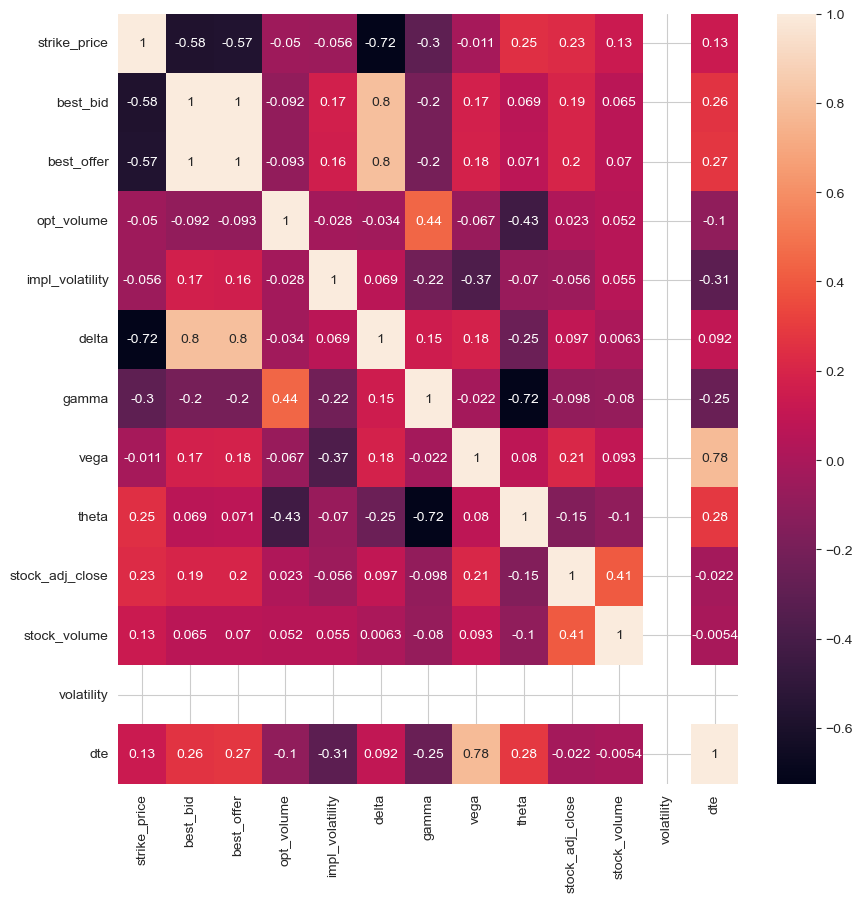

In [122]:
# Correlation plot of all the variables

columns_corr = ['strike_price','best_bid', 'best_offer', 
                'opt_volume','impl_volatility', 'delta', 
                'gamma', 'vega', 'theta',  
                'stock_adj_close', 'stock_volume', 'volatility', 'dte']
     

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
     
data = amd[columns_corr]
c=data.corr()
sns.heatmap(c, annot=True, ax=ax)
plt.show()

### Black-Scholes-Merton Models

Reference: World Quant University

In [133]:
import math
import QuantLib as ql

In [132]:

def option_price_european(
    S0, K, days_to_maturity, r, sigma, call=True, engine="BS", steps=200, paths=10000
):
    """
    This function returns the price of a European Call with 3 different price engines: BS, BT and MC.
    """

    # Setting up the dates
    today = ql.Date().todaysDate()
    maturity = today + days_to_maturity

    # Choosing the type of the option
    if call:
        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put

    # Creating the payoff
    payoff = ql.PlainVanillaPayoff(option_type, K)

    europeanExercise = ql.EuropeanExercise(maturity)
    europeanOption = ql.VanillaOption(payoff, europeanExercise)

    # Setting up the option's characteristics
    spot = ql.SimpleQuote(S0)
    riskFreeTS = ql.YieldTermStructureHandle(
        ql.FlatForward(today, r, ql.Actual365Fixed())
    )
    volTS = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed())
    )

    # We will use the analytical way of pricing the options
    process = ql.BlackScholesProcess(ql.QuoteHandle(spot), riskFreeTS, volTS)

    if engine == "BS":
        engine = ql.AnalyticEuropeanEngine(process)
    elif engine == "BT":
        engine = ql.BinomialVanillaEngine(process, "crr", steps)
    elif engine == "MC":
        engine = ql.MCEuropeanEngine(
            process, "PseudoRandom", timeSteps=steps, requiredSamples=paths
        )
    europeanOption.setPricingEngine(engine)

    return europeanOption.NPV()  # NPV stands for Net Present Value

def option_price_american(S0, K, days_to_maturity, r, sigma, call=True, steps=300):
    """
    This Function returns the price of an American option using a binomial tree
    """
    # Setting up the dates
    today = ql.Date().todaysDate()
    maturity = today + days_to_maturity

    # Choosing the type of the option
    if call:
        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put

    # Creating the payoff
    payoff = ql.PlainVanillaPayoff(option_type, K)

    americanExercise = ql.AmericanExercise(today, maturity)
    americanOption = ql.VanillaOption(payoff, americanExercise)

    # Setting up the option's characteristics
    spot = ql.SimpleQuote(S0)
    riskFreeTS = ql.YieldTermStructureHandle(
        ql.FlatForward(today, r, ql.Actual365Fixed())
    )
    volTS = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed())
    )
    process = ql.BlackScholesProcess(ql.QuoteHandle(spot), riskFreeTS, volTS)

    # We will use a binomial tree in order to price the american options
    engine = ql.BinomialVanillaEngine(process, "crr", steps)
    americanOption.setPricingEngine(engine)
    return americanOption.NPV()

In [126]:
callBS = round(
    option_price_european(
        100, 100, 30, 0.05, 0.2, call=True, engine="BS", steps=200, paths=10000
    ),
    4,
)
callBT = round(
    option_price_european(
        100, 100, 30, 0.05, 0.2, call=True, engine="BT", steps=200, paths=10000
    ),
    4,
)
callMC = round(
    option_price_european(
        100, 100, 30, 0.05, 0.2, call=True, engine="MC", steps=200, paths=10000
    ),
    4,
)
[callBS, callBT, callMC]

[2.4934, 2.4905, 2.5312]

In [134]:
putBS = round(
    option_price_european(
        100, 100, 30, 0.05, 0.2, call=False, engine="BS", steps=200, paths=10000
    ),
    4,
)
putBT = round(
    option_price_european(
        100, 100, 30, 0.05, 0.2, call=False, engine="BT", steps=200, paths=10000
    ),
    4,
)
putMC = round(
    option_price_european(
        100, 100, 30, 0.05, 0.2, call=False, engine="MC", steps=200, paths=10000
    ),
    4,
)

[putBS, putBT, putMC]

[2.0833, 2.0804, 2.0947]

In [128]:
c = callBS
p = putBS
round(c - p, 6)

0.4101

In [131]:
S = 100
K = 100
r = 0.05
t = 30 / 365
round(S - K * math.exp(-r * t), 6)

0.410116